In [1]:
import pandas as pd

df = pd.read_csv('GOOD_spotify_sim_copy.csv')

#only take the first 100 rows

df = df.head(100)

df

,artist,song
0,Elvis Costello,(The Angels Wanna Wear My) Red Shoes
1,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders..."
2,Tiffany Page,7 Years Too Late
3,Lissie,All Be Okay
4,Paul McCartney,Band On The Run
...,...,...
95,Ludwig van Beethoven,Für Elise
96,Ferdinand Lang & His Orchestra,Hungarian Dance No. 5
97,Ennio Morricone,L'Estasi Dell'oro (The Ecstasy Of Gold) - 2004...
98,Wolfgang Amadeus Mozart,"Piano Sonata No. 11 in A major, K. 331: III. R..."


In [2]:
df_playlist_data = pd.read_csv('Spotify-User-Only-Playlist-Data\spotify_dataset.csv', on_bad_lines='skip')

df_playlist_data = df_playlist_data.head(100)

df_playlist_data

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
95,9cc0cfd4d7d7885102480dd99e7a90d6,Bruce Springsteen,Queen Of The Supermarket,IOW 2012
96,9cc0cfd4d7d7885102480dd99e7a90d6,Thunderclap Newman,Something In The Air - Single Version,IOW 2012
97,9cc0cfd4d7d7885102480dd99e7a90d6,Biffy Clyro,The Captain,IOW 2012
98,9cc0cfd4d7d7885102480dd99e7a90d6,Thunderclap Newman,The Reason,IOW 2012


In [3]:
#print unique id for user_id

df_playlist_data['user_id'].unique()

array(['9cc0cfd4d7d7885102480dd99e7a90d6'], dtype=object)

In [5]:
import pandas as pd
import requests
from requests.exceptions import SSLError, RequestException
from concurrent.futures import ThreadPoolExecutor, as_completed

def get_spotify_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })
    auth_response_data = auth_response.json()
    print("token acquired")
    return auth_response_data['access_token']


def search_artist(access_token, artist_name):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }
    params = {
        'q': artist_name,
        'type': 'artist',
        'limit': 1
    }
    try:
        search_response = requests.get(search_url, headers=headers, params=params)
        print(f"searching for {artist_name}")
        search_response.raise_for_status()  # Raises stored HTTPError, if one occurred
        print("got search response")
        search_data = search_response.json()
        print("got search data")
        artists_items = search_data['artists']['items']
        print("got artists items")
        if not artists_items:
            print(f"{artist_name} not found")
            return artist_name, None, None
        artist_id = artists_items[0]['id']
        artist_genre = artists_items[0]['genres']
        print(f"got artist id {artist_id}")
        print(f"got artist genre {', '.join(artist_genre)}")  # Convert genre list to string before printing
        return artist_name, artist_id, artist_genre
    except (SSLError, RequestException) as error:
        print(f"Error fetching {artist_name}: {error}")
        return artist_name, "Error", "Error"

def fetch_artists_data(access_token, artists_names):
    results = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(search_artist, access_token, name) for name in artists_names]
        for future in as_completed(futures):
            results.append(future.result())
    return results

# Use your own Client ID and Client Secret
client_id = '4a21432c16e14ab0be1c74654d4e6134'
client_secret = '65af98e0e3af4a8f89789ee5f28b87fe'

# Get access token
access_token = get_spotify_token(client_id, client_secret)

# Load the CSV file
spotify_data = df

# Ensure correct column names
if 'artist' not in spotify_data.columns:
    print("Expected 'artist' column not found. Available columns:", spotify_data.columns)
else:
    artist_names = spotify_data['artist'].tolist()
    artist_data = fetch_artists_data(access_token, artist_names)
    # Update DataFrame with fetched data
    for artist_name, artist_id, genre in artist_data:
        spotify_data.loc[spotify_data['artist'] == artist_name, 'Artist ID'] = artist_id
        spotify_data.loc[spotify_data['artist'] == artist_name, 'Genre'] = ', '.join(genre) if genre else "Not Found"

spotify_data

token acquired
searching for Lissie
got search response
got search data
got artists items
got artist id 3j4FHbC5zwmYGJ7r0ZgaMt
got artist genre folk-pop
searching for Joe Echo
got search response
got search data
got artists items
got artist id 2bekbCTQa7ve7sz4z4RvPK
got artist genre 
searching for Joshua Radin
got search response
got search data
got artists items
got artist id 7omzannyG2lfDqP5xyZo34
got artist genre acoustic pop, neo mellow
searching for The Coronas
got search response
got search data
got artists items
got artist id 2tppd6KkhK4ULAd217Ecq1
got artist genre irish rock
searching for Elvis Costello
got search response
got search data
got artists items
got artist id 2BGRfQgtzikz1pzAD0kaEn
got artist genre new wave, new wave pop, permanent wave, power pop, singer-songwriter
searching for Elvis Costello & The Attractions
got search response
got search data
got artists items
got artist id 4qmHkMxr6pTWh5Zo74odpH
got artist genre art rock, heartland rock, new romantic, new wave,

,artist,song,Artist ID,Genre
0,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,2BGRfQgtzikz1pzAD0kaEn,"new wave, new wave pop, permanent wave, power ..."
1,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",4qmHkMxr6pTWh5Zo74odpH,"art rock, heartland rock, new romantic, new wa..."
2,Tiffany Page,7 Years Too Late,1Q6EgKHZ8mt7Hm5bKa6DbG,Not Found
3,Lissie,All Be Okay,3j4FHbC5zwmYGJ7r0ZgaMt,folk-pop
4,Paul McCartney,Band On The Run,4STHEaNw4mPZ2tzheohgXB,"classic rock, mellow gold, rock, soft rock"
...,...,...,...,...
95,Ludwig van Beethoven,Für Elise,2wOqMjp9TyABvtHdOSOTUS,"classical, classical era, early romantic era, ..."
96,Ferdinand Lang & His Orchestra,Hungarian Dance No. 5,14KasUtREzgzLxrj6x7biD,Not Found
97,Ennio Morricone,L'Estasi Dell'oro (The Ecstasy Of Gold) - 2004...,1nIUhcKHnK6iyumRyoV68C,"classic soundtrack, italian soundtrack, orches..."
98,Wolfgang Amadeus Mozart,"Piano Sonata No. 11 in A major, K. 331: III. R...",4NJhFmfw43RLBLjQvxDuRS,"classical, classical era"


In [10]:
import pandas as pd

if 'Genre' in spotify_data.columns:
    # Split the 'Genre' column into separate columns at each comma
    genre_expanded = spotify_data['Genre'].str.split(',', expand=True)
    
    # Rename columns to "Genre 1", "Genre 2", etc.
    for i in range(genre_expanded.shape[1]):
        genre_expanded.rename(columns={i: f'Genre {i+1}'}, inplace=True)
    # Join the new columns back to the original DataFrame
    spotify_data = pd.concat([spotify_data, genre_expanded], axis=1)
    spotify_data.drop('Genre', axis=1, inplace=True)

else:
    print("The 'Genre' column was not found in the DataFrame.")

spotify_data

The 'Genre' column was not found in the DataFrame.


,artist,song,Artist ID,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9
0,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop,singer-songwriter,None,None,None,None
1,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,new wave pop,power pop,None,None,None
2,Tiffany Page,7 Years Too Late,1Q6EgKHZ8mt7Hm5bKa6DbG,Not Found,None,None,None,None,None,None,None,None
3,Lissie,All Be Okay,3j4FHbC5zwmYGJ7r0ZgaMt,folk-pop,None,None,None,None,None,None,None,None
4,Paul McCartney,Band On The Run,4STHEaNw4mPZ2tzheohgXB,classic rock,mellow gold,rock,soft rock,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Ludwig van Beethoven,Für Elise,2wOqMjp9TyABvtHdOSOTUS,classical,classical era,early romantic era,german romanticism,None,None,None,None,None
96,Ferdinand Lang & His Orchestra,Hungarian Dance No. 5,14KasUtREzgzLxrj6x7biD,Not Found,None,None,None,None,None,None,None,None
97,Ennio Morricone,L'Estasi Dell'oro (The Ecstasy Of Gold) - 2004...,1nIUhcKHnK6iyumRyoV68C,classic soundtrack,italian soundtrack,orchestral soundtrack,vintage italian soundtrack,None,None,None,None,None
98,Wolfgang Amadeus Mozart,"Piano Sonata No. 11 in A major, K. 331: III. R...",4NJhFmfw43RLBLjQvxDuRS,classical,classical era,None,None,None,None,None,None,None


In [11]:
#count of "None" in each column. replace them NaN
spotify_data.replace('None', pd.NA, inplace=True)
spotify_data.isna().sum()

artist        0
song          0
Artist ID     0
Genre 1       0
Genre 2      28
Genre 3      44
Genre 4      59
Genre 5      76
Genre 6      83
Genre 7      88
Genre 8      94
Genre 9      97
dtype: int64

In [12]:
#drop columns Genre 5, Genre 6, Genre 7, Genre 8, Genre 9

spotify_data.drop(columns=['Genre 5', 'Genre 6', 'Genre 7', 'Genre 8', 'Genre 9'], inplace=True)

spotify_data

,artist,song,Artist ID,Genre 1,Genre 2,Genre 3,Genre 4
0,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop
1,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave
2,Tiffany Page,7 Years Too Late,1Q6EgKHZ8mt7Hm5bKa6DbG,Not Found,None,None,None
3,Lissie,All Be Okay,3j4FHbC5zwmYGJ7r0ZgaMt,folk-pop,None,None,None
4,Paul McCartney,Band On The Run,4STHEaNw4mPZ2tzheohgXB,classic rock,mellow gold,rock,soft rock
...,...,...,...,...,...,...,...
95,Ludwig van Beethoven,Für Elise,2wOqMjp9TyABvtHdOSOTUS,classical,classical era,early romantic era,german romanticism
96,Ferdinand Lang & His Orchestra,Hungarian Dance No. 5,14KasUtREzgzLxrj6x7biD,Not Found,None,None,None
97,Ennio Morricone,L'Estasi Dell'oro (The Ecstasy Of Gold) - 2004...,1nIUhcKHnK6iyumRyoV68C,classic soundtrack,italian soundtrack,orchestral soundtrack,vintage italian soundtrack
98,Wolfgang Amadeus Mozart,"Piano Sonata No. 11 in A major, K. 331: III. R...",4NJhFmfw43RLBLjQvxDuRS,classical,classical era,None,None


Join the two datasets together

In [21]:
#match wherever the artist name in the playlist data matches the artist name in the spotify data
df_playlist_data.columns

#rename all column names to exclude quotes "" and spaces
df_playlist_data.columns = df_playlist_data.columns.str.replace('"', '').str.replace(' ', '_').str.lower()
#rename all column names to exclude _
df_playlist_data.columns = df_playlist_data.columns.str.replace('_', '')
#drop 'name' in each column
df_playlist_data.columns = df_playlist_data.columns.str.replace('name', '')

df_playlist_data.columns

Index(['userid', 'artist', 'track', 'playlist'], dtype='object')

In [22]:
df_playlist_data

,userid,artist,track,playlist
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
95,9cc0cfd4d7d7885102480dd99e7a90d6,Bruce Springsteen,Queen Of The Supermarket,IOW 2012
96,9cc0cfd4d7d7885102480dd99e7a90d6,Thunderclap Newman,Something In The Air - Single Version,IOW 2012
97,9cc0cfd4d7d7885102480dd99e7a90d6,Biffy Clyro,The Captain,IOW 2012
98,9cc0cfd4d7d7885102480dd99e7a90d6,Thunderclap Newman,The Reason,IOW 2012


In [30]:
#use artist to match with artist in spotify data to merge the two datasets together

merged_data = pd.merge(df_playlist_data, spotify_data, left_on='artist', right_on='artist', how='inner')

merged_data.drop(columns=['song'], inplace=True)

merged_data

,userid,artist,track,playlist,Artist ID,Genre 1,Genre 2,Genre 3,Genre 4
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave
...,...,...,...,...,...,...,...,...,...
95,9cc0cfd4d7d7885102480dd99e7a90d6,Elbow,Grounds For Divorce,IOW 2012,0TJB3EE2efClsYIDQ8V2Jk,britpop,None,None,None
96,9cc0cfd4d7d7885102480dd99e7a90d6,Elbow,One Day Like This,IOW 2012,0TJB3EE2efClsYIDQ8V2Jk,britpop,None,None,None
97,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave
98,9cc0cfd4d7d7885102480dd99e7a90d6,Thunderclap Newman,Something In The Air - Single Version,IOW 2012,1USHlPahTZrCeJXS2v5pkF,classic uk pop,None,None,None


In [28]:
audio_features = pd.read_csv('audio_features.csv', on_bad_lines='skip')

audio_features

,(The Angels Wanna Wear My) Red Shoes,0.577,0.636,4,-9.825,1,0.0491,0.0556,0.00016,0.226,0.901,134.768,167680,4.1
0,"(What's So Funny 'Bout) Peace, Love And Unders...",0.381,0.918,7,-9.451,1,0.0803,0.000466,0.05110,0.3210,0.368,142.340,211630,4
1,Accidents Will Happen,0.608,0.597,0,-11.115,1,0.0276,0.044100,0.00342,0.2850,0.736,120.077,181720,4
2,Alison,0.557,0.320,1,-10.792,0,0.0438,0.739000,0.00004,0.1120,0.377,176.647,204533,4
3,Band On The Run,0.479,0.601,7,-8.806,1,0.0318,0.083200,0.00142,0.1100,0.669,124.966,313027,4
4,Dance Tonight,0.531,0.891,5,-2.539,1,0.0431,0.082300,0.00551,0.1610,0.926,170.973,174933,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11383,Can You Imagine,0.674,0.865,10,-6.276,0,0.2330,0.179000,0.00000,0.3190,0.822,96.044,228240,4
11384,Garbage Pail Kid,0.674,0.865,10,-6.276,0,0.2330,0.179000,0.00000,0.3190,0.822,96.044,228240,4
11385,Johnny Raincloud Blues,0.625,0.720,10,-5.791,0,0.2820,0.447000,0.00000,0.1730,0.727,93.477,211867,4
11386,Keep It Flowing,0.552,0.833,0,-6.412,1,0.2260,0.176000,0.00000,0.0922,0.849,90.935,225147,4


In [31]:
#assign the following column labels to the top of this dataset

column_names = ['track', 'danceability', "energy","key", "loudness", "mode",
                    "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

audio_features.columns = column_names

audio_features

,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"(What's So Funny 'Bout) Peace, Love And Unders...",0.381,0.918,7,-9.451,1,0.0803,0.000466,0.05110,0.3210,0.368,142.340,211630,4
1,Accidents Will Happen,0.608,0.597,0,-11.115,1,0.0276,0.044100,0.00342,0.2850,0.736,120.077,181720,4
2,Alison,0.557,0.320,1,-10.792,0,0.0438,0.739000,0.00004,0.1120,0.377,176.647,204533,4
3,Band On The Run,0.479,0.601,7,-8.806,1,0.0318,0.083200,0.00142,0.1100,0.669,124.966,313027,4
4,Dance Tonight,0.531,0.891,5,-2.539,1,0.0431,0.082300,0.00551,0.1610,0.926,170.973,174933,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11383,Can You Imagine,0.674,0.865,10,-6.276,0,0.2330,0.179000,0.00000,0.3190,0.822,96.044,228240,4
11384,Garbage Pail Kid,0.674,0.865,10,-6.276,0,0.2330,0.179000,0.00000,0.3190,0.822,96.044,228240,4
11385,Johnny Raincloud Blues,0.625,0.720,10,-5.791,0,0.2820,0.447000,0.00000,0.1730,0.727,93.477,211867,4
11386,Keep It Flowing,0.552,0.833,0,-6.412,1,0.2260,0.176000,0.00000,0.0922,0.849,90.935,225147,4


In [32]:
#join data based on track column

final_data = pd.merge(merged_data, audio_features, left_on='track', right_on='track', how='inner')

final_data

,userid,artist,track,playlist,Artist ID,Genre 1,Genre 2,Genre 3,Genre 4,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop,0.557,...,-10.792,0,0.0438,0.739000,0.00004,0.112,0.377,176.647,204533,4
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop,0.403,...,-9.955,1,0.0300,0.485000,0.00000,0.326,0.302,143.598,341333,3
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.381,...,-9.451,1,0.0803,0.000466,0.05110,0.321,0.368,142.340,211630,4
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.608,...,-11.115,1,0.0276,0.044100,0.00342,0.285,0.736,120.077,181720,4
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Oliver's Army,HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.527,...,-9.405,1,0.0287,0.336000,0.00000,0.221,0.940,143.162,180840,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,9cc0cfd4d7d7885102480dd99e7a90d6,Elbow,One Day Like This,IOW 2012,0TJB3EE2efClsYIDQ8V2Jk,britpop,None,None,None,0.433,...,-6.102,1,0.0287,0.093000,0.00000,0.141,0.382,159.369,394173,4
97,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.405,...,-5.132,1,0.0273,0.031600,0.00251,0.112,0.141,145.936,292853,4
98,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.618,...,-8.423,0,0.0376,0.427000,0.41500,0.213,0.603,115.623,267154,4
99,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.618,...,-8.423,0,0.0376,0.427000,0.41500,0.213,0.603,115.623,267154,4


Actual ML stuff

In [40]:
# create several models to create a user profile based on an aggregation of the final data

# create a model that takes the average of all the audio features

final_data['danceability'] = final_data['danceability'].astype(float)
final_data['energy'] = final_data['energy'].astype(float)
final_data['key'] = final_data['key'].astype(float)
final_data['loudness'] = final_data['loudness'].astype(float)
final_data['mode'] = final_data['mode'].astype(float)
final_data['speechiness'] = final_data['speechiness'].astype(float)
final_data['acousticness'] = final_data['acousticness'].astype(float)
final_data['instrumentalness'] = final_data['instrumentalness'].astype(float)
final_data['liveness'] = final_data['liveness'].astype(float)
final_data['valence'] = final_data['valence'].astype(float)
final_data['tempo'] = final_data['tempo'].astype(float)
final_data['duration_ms'] = final_data['duration_ms'].astype(float)

final_data.dtypes


userid                object
artist                object
track                 object
playlist              object
Artist ID             object
Genre 1             category
Genre 2             category
Genre 3             category
Genre 4             category
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
time_signature        object
dtype: object

In [41]:
#convert  Genre 1, Genre 2, Genre 3, Genre 4
# to category

final_data['Genre 1'] = final_data['Genre 1'].astype('category')
final_data['Genre 2'] = final_data['Genre 2'].astype('category')
final_data['Genre 3'] = final_data['Genre 3'].astype('category')
final_data['Genre 4'] = final_data['Genre 4'].astype('category')


final_data.dtypes


userid                object
artist                object
track                 object
playlist              object
Artist ID             object
Genre 1             category
Genre 2             category
Genre 3             category
Genre 4             category
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
time_signature        object
dtype: object

In [42]:
final_data

,userid,artist,track,playlist,Artist ID,Genre 1,Genre 2,Genre 3,Genre 4,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop,0.557,...,-10.792,0.0,0.0438,0.739000,0.00004,0.112,0.377,176.647,204533.0,4
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010,2BGRfQgtzikz1pzAD0kaEn,new wave,new wave pop,permanent wave,power pop,0.403,...,-9.955,1.0,0.0300,0.485000,0.00000,0.326,0.302,143.598,341333.0,3
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.381,...,-9.451,1.0,0.0803,0.000466,0.05110,0.321,0.368,142.340,211630.0,4
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.608,...,-11.115,1.0,0.0276,0.044100,0.00342,0.285,0.736,120.077,181720.0,4
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Oliver's Army,HARD ROCK 2010,4qmHkMxr6pTWh5Zo74odpH,art rock,heartland rock,new romantic,new wave,0.527,...,-9.405,1.0,0.0287,0.336000,0.00000,0.221,0.940,143.162,180840.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,9cc0cfd4d7d7885102480dd99e7a90d6,Elbow,One Day Like This,IOW 2012,0TJB3EE2efClsYIDQ8V2Jk,britpop,None,None,None,0.433,...,-6.102,1.0,0.0287,0.093000,0.00000,0.141,0.382,159.369,394173.0,4
97,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.405,...,-5.132,1.0,0.0273,0.031600,0.00251,0.112,0.141,145.936,292853.0,4
98,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.618,...,-8.423,0.0,0.0376,0.427000,0.41500,0.213,0.603,115.623,267154.0,4
99,9cc0cfd4d7d7885102480dd99e7a90d6,Oasis,Little By Little,IOW 2012,2DaxqgrOhkeH0fpeiQq2f4,beatlesque,britpop,madchester,permanent wave,0.618,...,-8.423,0.0,0.0376,0.427000,0.41500,0.213,0.603,115.623,267154.0,4


In [48]:
# Fixing the imports and running the corrected code for KNN classification to predict Genre 1
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Preparing data for KNN
knn_data = data.drop(['Genre 2', 'Genre 3', 'Genre 4'], axis=1)

# Encoding categorical variables and target
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(knn_data.drop(['Genre 1'], axis=1))
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Encode target
target_encoder = LabelEncoder()
target = target_encoder.fit_transform(knn_data['Genre 1'])


# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_features_df, target, test_size=0.2, random_state=42)

# Adjust the code to correctly handle the target names in the classification report
unique_labels = sorted(set(y_test))  # Unique labels in the test set
target_names = target_encoder.inverse_transform(unique_labels)  # Corresponding genre names


# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions and evaluation
y_pred = knn.predict(X_test)
# Adjust the code to correctly handle the target names in the classification report
unique_labels = sorted(set(y_test))  # Unique labels in the test set
target_names = target_encoder.inverse_transform(unique_labels)  # Corresponding genre names

# Generate the classification report with corrected labels
report = classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names)
accuracy = accuracy_score(y_test, y_pred)

accuracy, report



c:\Users\arush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\arush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\arush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\User

(0.8571428571428571,
 '                     precision    recall  f1-score   support\n\n          Not Found       0.00      0.00      0.00         1\n       acoustic pop       0.50      1.00      0.67         1\n  alternative metal       1.00      1.00      1.00         1\n           art rock       1.00      1.00      1.00         1\n    australian rock       1.00      1.00      1.00         1\n        baroque pop       1.00      1.00      1.00         1\n         beatlesque       1.00      1.00      1.00         1\n            britpop       1.00      0.67      0.80         3\n       classic rock       1.00      1.00      1.00         2\ngarage rock revival       0.75      1.00      0.86         3\n     heartland rock       1.00      1.00      1.00         2\n        modern rock       1.00      1.00      1.00         1\n           new wave       0.00      0.00      0.00         1\n   stomp and holler       1.00      1.00      1.00         2\n\n          micro avg       0.90      0.86   

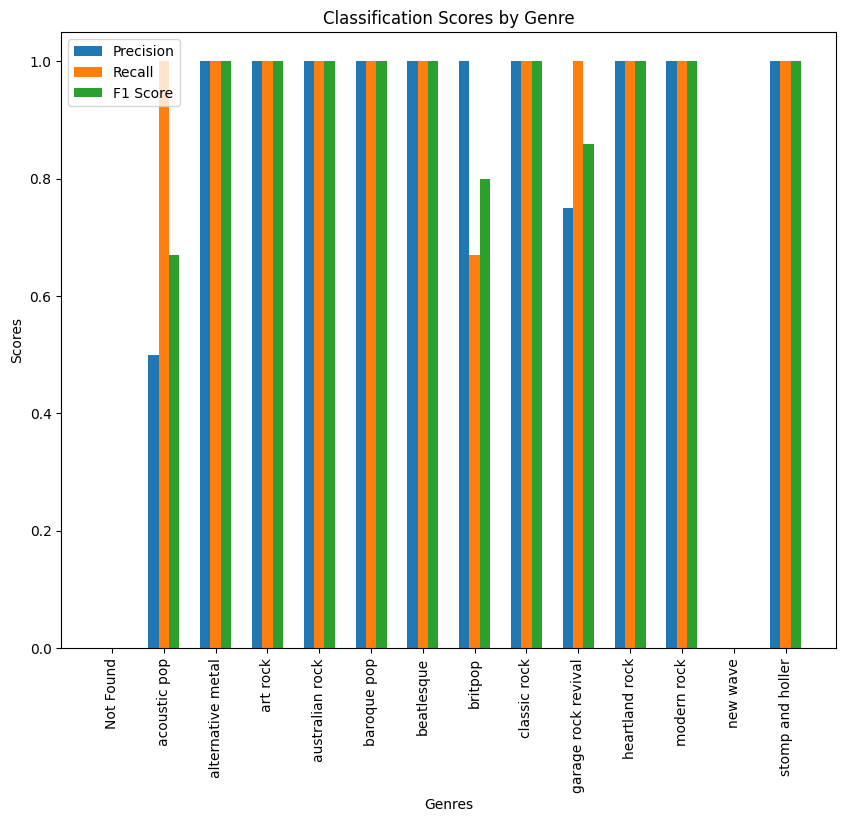

In [49]:
import matplotlib.pyplot as plt

# Data for plotting
labels = target_names
precision = [0.00, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.75, 1.00, 1.00, 0.00, 1.00]
recall = [0.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.67, 1.00, 1.00, 1.00, 1.00, 0.00, 1.00]
f1_scores = [0.00, 0.67, 1.00, 1.00, 1.00, 1.00, 1.00, 0.80, 1.00, 0.86, 1.00, 1.00, 0.00, 1.00]

x = range(len(labels))

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(x, precision, width=0.2, label='Precision', align='center')
ax.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
ax.bar([p + 0.4 for p in x], f1_scores, width=0.2, label='F1 Score', align='center')

ax.set_xlabel('Genres')
ax.set_ylabel('Scores')
ax.set_title('Classification Scores by Genre')
ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(labels, rotation=90)
ax.legend()

plt.show()


neural nets version

c:\Users\arush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Cross-validation accuracies: [90.47619104385376, 89.99999761581421, 69.9999988079071, 89.99999761581421, 89.99999761581421]
Average accuracy: 86.0952365398407


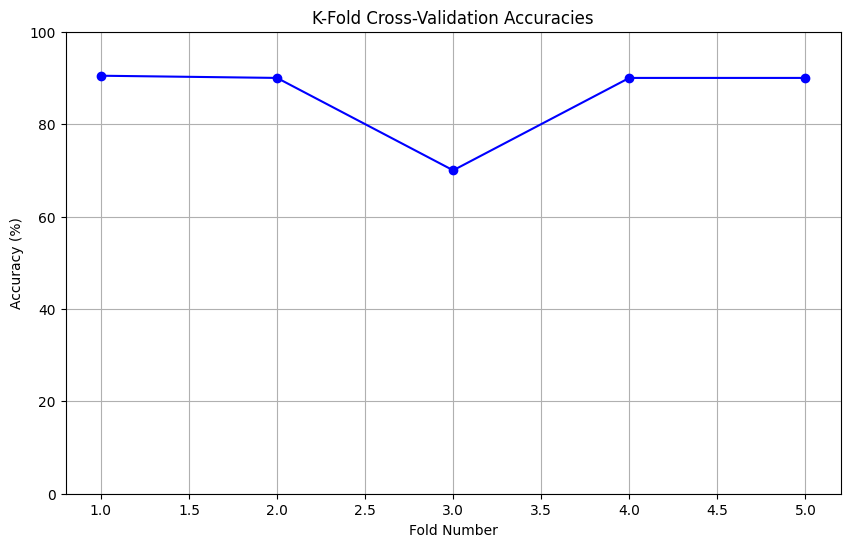

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Function to create the model
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, input_shape=(input_dim,), activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load and prepare data
data = final_data  # Update the path to your dataset
nn_data = data.drop(['Genre 2', 'Genre 3', 'Genre 4'], axis=1)

# One-hot encoding for categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(nn_data.drop(['Genre 1'], axis=1))
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Encoding the target variable
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nn_data['Genre 1'])
one_hot_labels = to_categorical(encoded_labels)

# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate the model
accuracies = []
for train, test in kfold.split(encoded_features_df, one_hot_labels):
    # Create model
    model = create_model(input_dim=encoded_features_df.shape[1], num_classes=one_hot_labels.shape[1])
    
    # Fit model
    model.fit(encoded_features_df.iloc[train], one_hot_labels[train], epochs=50, batch_size=10, verbose=0)
    
    # Evaluate model
    scores = model.evaluate(encoded_features_df.iloc[test], one_hot_labels[test], verbose=0)
    accuracies.append(scores[1] * 100)

# Average and print accuracies
print('Cross-validation accuracies:', accuracies)
print('Average accuracy:', np.mean(accuracies))

# Optionally, plot the accuracies for visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', linestyle='-', color='b')
plt.title('K-Fold Cross-Validation Accuracies')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.show()


User Profile

In [1]:
user_profile_data = pd.read_csv('final_data.csv', on_bad_lines='skip')

NameError: name 'pd' is not defined